In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#prefer locally cached copy of SQL Server data
runSql = True

### Load data for each runners in AU Thoroughbreds

In [2]:
runnerSql = '''
SELECT rnr.RunnerName, rnr.RunnerNumber, rnr.FixedWinOpen, rnr.FixedWin, rnr.FixedPlace, rnr.BettingStatus,
m.MeetingDate, m.MeetingName, r.RaceNumber from TabRace r 
inner join TabMeeting m on m.TabMeetingId = r.TabMeetingId 
inner join TabRunner rnr on rnr.[TabRaceId] = r.TabRaceId
where m.MeetingDate >= '1 Jan 2016' and m.RaceType = 'R'
and JSON_VALUE(m.[RawData], '$.location') in ('NSW', 'QLD', 'VIC', 'ACT', 'TAS', 'SA', 'NT', 'WA') 
order by m.MeetingDate
'''
if runSql:
    cnxn = pyodbc.connect(open('credentials.xxx').readline())
    runners = pd.read_sql(runnerSql,cnxn)
    runners.to_csv('fd_runners.csv', index=False, date_format='%Y%m%d')

runners = pd.read_csv('fd_runners.csv')
runners['MeetingDate'] = pd.to_datetime(runners['MeetingDate'], format="%Y-%m-%d")
runners.head()

,RunnerName,RunnerNumber,FixedWinOpen,FixedWin,FixedPlace,BettingStatus,MeetingDate,MeetingName,RaceNumber
0,BLINKIN' DISCO,1,15.0,21.0,5.00,Loser,2016-01-01,INVERELL,1
1,HIT HIM AGAIN,2,0.0,0.0,0.00,LateScratched,2016-01-01,INVERELL,1
2,HUSONIQUE,3,26.0,51.0,11.00,Loser,2016-01-01,INVERELL,1
3,JONATHAN,4,4.6,4.6,1.72,Placing,2016-01-01,INVERELL,1
4,NICE ONE SON,5,51.0,26.0,6.00,Loser,2016-01-01,INVERELL,1


### Load the deductions for each race so WinOpen can be adjusted to real payout price

In [3]:
deductionSql = '''
SELECT  m.MeetingDate, m.MeetingName, r.RaceNumber, JSON_VALUE(x.[value],'$.runnerNumber') AS RunnerNumber, ISNULL(JSON_VALUE(x.[value],'$.fixedOdds.winDeduction'), 0) AS WinDeduction
FROM [dbo].[TabRace] r CROSS APPLY OPENJSON(JSON_QUERY([RawData],'$.scratchings')) AS x
inner join [dbo].[TabMeeting] m on m.TabMeetingId = r.TabMeetingId
where m.MeetingDate >= '1 Jan 2016' and m.RaceType = 'R'
and JSON_VALUE(m.[RawData], '$.location') in ('NSW', 'QLD', 'VIC', 'ACT', 'TAS', 'SA', 'NT', 'WA') 
order by m.MeetingDate, m.MeetingName, r.RaceNumber
'''
if runSql:
    cnxn = pyodbc.connect(open('credentials.xxx').readline())
    deductions = pd.read_sql(deductionSql,cnxn)
    deductions.to_csv('fd_deductions.csv', index=False, date_format='%Y%m%d')

deductions = pd.read_csv('fd_deductions.csv')
deductions['MeetingDate'] = pd.to_datetime(deductions['MeetingDate'], format="%Y-%m-%d")

deductionsGrouped = deductions.groupby(['MeetingDate', 'MeetingName', 'RaceNumber']).agg({'WinDeduction':['sum']})
deductionsGrouped = deductionsGrouped.reset_index()
deductionsGrouped.columns =['DATE_D', 'TRACK_D', 'RACE_D', 'WinDeductionSum']

deductionsGrouped.head(10)

,DATE_D,TRACK_D,RACE_D,WinDeductionSum
0,2016-01-01,BUNBURY,2,0
1,2016-01-01,BUNBURY,3,0
2,2016-01-01,BUNBURY,4,0
3,2016-01-01,BUNBURY,6,0
4,2016-01-01,BUNBURY,7,0
5,2016-01-01,DOOMBEN,1,0
6,2016-01-01,DOOMBEN,2,10
7,2016-01-01,DOOMBEN,3,0
8,2016-01-01,DOOMBEN,4,19
9,2016-01-01,DOOMBEN,5,5


### Correct FixedWinOpen for Deductions

In [4]:
runners = pd.merge(runners, deductionsGrouped, how='left', left_on=['MeetingDate','MeetingName', 'RaceNumber',], right_on = ['DATE_D', 'TRACK_D', 'RACE_D'])
runners.WinDeductionSum.fillna(0, inplace=True)
runners.drop(columns=['DATE_D', 'TRACK_D', 'RACE_D'], inplace=True)
runners['FixedWinOpenAdjusted'] = (runners['FixedWinOpen'] - 1) * (1 - runners['WinDeductionSum']/100) + 1

### Calculate Market % and  add normalised FixWin as this should be equal to real probability

In [5]:
#probability of a runner winner without normalisation
runners['RawProb'] = 1/ runners['FixedWin']
runners['RawProbOpenAdjusted'] = 1/ runners['FixedWinOpenAdjusted']
#calculate bookies markup for each race at jump
raceStarters = runners[runners.BettingStatus.isin(['Loser', 'Placing', 'Winner'])] #exclude scratchings and other runner status
raceVig = raceStarters.groupby(['MeetingDate', 'MeetingName', 'RaceNumber'])['RawProb'].sum().to_frame()

#reshape into flat DF
raceVig = raceVig.stack().reset_index().drop(columns=['level_3']).rename(columns={0: 'MarketPct'})

raceVig.columns =['MeetingDate_V', 'MeetingName_V', 'RaceNumber_V', 'MarketPct']

raceVig.head()

,MeetingDate_V,MeetingName_V,RaceNumber_V,MarketPct
0,2016-01-01,BUNBURY,1,1.191380
1,2016-01-01,BUNBURY,2,1.182621
2,2016-01-01,BUNBURY,3,1.187490
3,2016-01-01,BUNBURY,4,1.190244
4,2016-01-01,BUNBURY,5,1.210967


In [6]:
#merge margin calcs onto original DF and normalise probability of each runner
runners = pd.merge(runners, raceVig,  how='inner', left_on=['MeetingDate','MeetingName', 'RaceNumber'], right_on = ['MeetingDate_V','MeetingName_V', 'RaceNumber_V'])
runners.drop(columns=['MeetingDate_V', 'MeetingName_V', 'RaceNumber_V'], inplace=True)
runners['RealProd'] = runners['RawProb'] / runners['MarketPct']
runners['RealPrice'] = 1 / runners['RealProd']

runners.head(20)

,RunnerName,RunnerNumber,FixedWinOpen,FixedWin,FixedPlace,BettingStatus,MeetingDate,MeetingName,RaceNumber,WinDeductionSum,FixedWinOpenAdjusted,RawProb,RawProbOpenAdjusted,MarketPct,RealProd,RealPrice
0,BLINKIN' DISCO,1,15.0,21.0,5.00,Loser,2016-01-01,INVERELL,1,0.0,15.0,0.047619,0.066667,1.217368,0.039116,25.564731
1,HIT HIM AGAIN,2,0.0,0.0,0.00,LateScratched,2016-01-01,INVERELL,1,0.0,0.0,inf,inf,1.217368,inf,0.000000
2,HUSONIQUE,3,26.0,51.0,11.00,Loser,2016-01-01,INVERELL,1,0.0,26.0,0.019608,0.038462,1.217368,0.016107,62.085775
3,JONATHAN,4,4.6,4.6,1.72,Placing,2016-01-01,INVERELL,1,0.0,4.6,0.217391,0.217391,1.217368,0.178575,5.599893
4,NICE ONE SON,5,51.0,26.0,6.00,Loser,2016-01-01,INVERELL,1,0.0,51.0,0.038462,0.019608,1.217368,0.031594,31.651572
5,SPYRO DRAGON,6,15.0,13.0,3.40,Loser,2016-01-01,INVERELL,1,0.0,15.0,0.076923,0.066667,1.217368,0.063188,15.825786
6,MISS BONNIE,13,4.6,6.0,2.00,Loser,2016-01-01,INVERELL,1,0.0,4.6,0.166667,0.217391,1.217368,0.136907,7.304209
7,DUCHILLI,14,0.0,0.0,0.00,LateScratched,2016-01-01,INVERELL,1,0.0,0.0,inf,inf,1.217368,inf,0.000000
8,ALLY OLE,15,0.0,0.0,0.00,LateScratched,2016-01-01,INVERELL,1,0.0,0.0,inf,inf,1.217368,inf,0.000000
9,ADAYONDEK,16,0.0,0.0,0.00,LateScratched,2016-01-01,INVERELL,1,0.0,0.0,inf,inf,1.217368,inf,0.000000


In [7]:
runners['WIN'] = runners.BettingStatus == 'Winner'
raceStarters = runners[runners.BettingStatus.isin(['Loser', 'Placing', 'Winner'])]

In [8]:
len(raceStarters)

614141

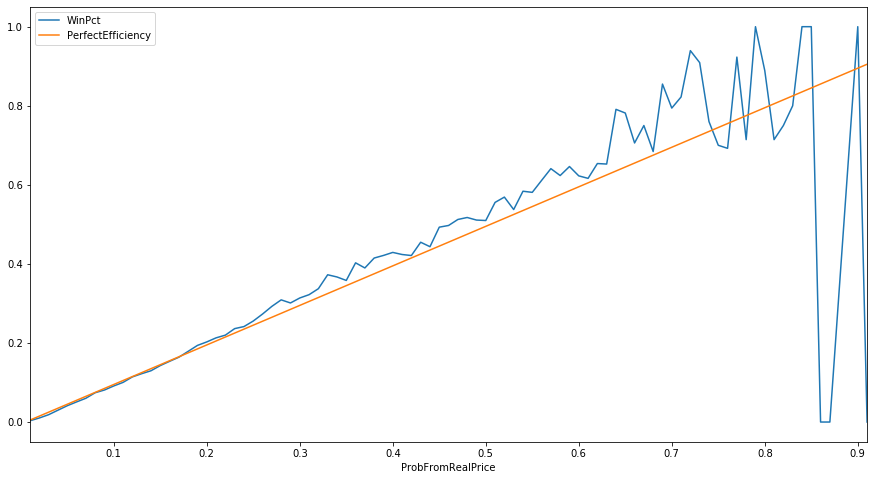

In [9]:
winPctByPrice = pd.DataFrame(columns=['ProbFromRealPrice', 'WinPct', 'PerfectEfficiency'])
ix = 0
for n in range(1,100):
    prob_floor = (n-1) / 100
    prob_ceiling = n / 100
    winPct = raceStarters[(raceStarters.RealProd >= prob_floor) & (raceStarters.RealProd < prob_ceiling)].WIN.mean()
    winPctByPrice.loc[ix] = [prob_ceiling, winPct, (prob_floor + prob_ceiling)/2]
    ix = ix + 1
        
winPctByPrice.dropna(inplace=True)
winPctByPrice.plot(x='ProbFromRealPrice', y=['WinPct', 'PerfectEfficiency'], figsize=(15,8))

## Plot for probability as given by the starting price (without normalisation)

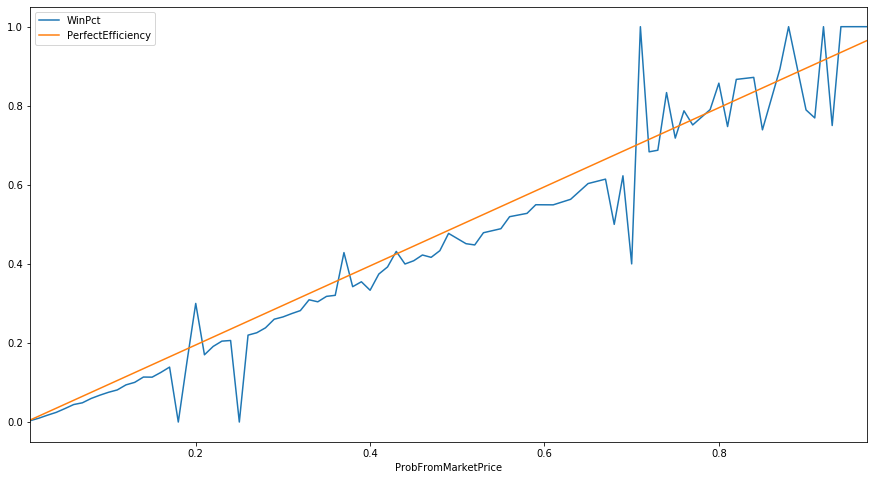

In [10]:
winPctByPrice = pd.DataFrame(columns=['ProbFromMarketPrice', 'WinPct', 'PerfectEfficiency'])
ix = 0
for n in range(1,100, 1):
    prob_floor = (n-1) / 100
    prob_ceiling = n / 100
    winPct = raceStarters[(raceStarters.RawProb >= prob_floor) & (raceStarters.RawProb < prob_ceiling)].WIN.mean()
    winPctByPrice.loc[ix] = [prob_ceiling, winPct, (prob_floor + prob_ceiling)/2]
    ix = ix + 1
        

winPctByPrice.dropna(inplace=True)
winPctByPrice.plot(x='ProbFromMarketPrice', y=['WinPct', 'PerfectEfficiency'], figsize=(15,8))

## Repeat for runners that have drifted 25% or more

In [11]:
drifters = raceStarters[(raceStarters.RawProbOpenAdjusted - raceStarters.RawProb) > 0.25]
drifters.head()

,RunnerName,RunnerNumber,FixedWinOpen,FixedWin,FixedPlace,BettingStatus,MeetingDate,MeetingName,RaceNumber,WinDeductionSum,FixedWinOpenAdjusted,RawProb,RawProbOpenAdjusted,MarketPct,RealProd,RealPrice,WIN
638,STANDUP'N'DELIVER,1,1.3,3.0,1.34,Placing,2016-01-01,BUNBURY,3,0.0,1.300,0.333333,0.769231,1.187490,0.280704,3.562471,False
2974,GET ON THE GRANGE,1,2.3,3.2,1.65,Loser,2016-01-07,WARWICK FARM,5,49.0,1.663,0.312500,0.601323,1.131383,0.276211,3.620425,False
3702,TASHBEEH,3,1.9,3.6,1.65,Winner,2016-01-09,CAULFIELD,3,36.0,1.576,0.277778,0.634518,1.128604,0.246125,4.062973,True
4600,BILL 'N' EVE,1,1.8,3.3,1.57,Loser,2016-01-10,COWRA,1,0.0,1.800,0.303030,0.555556,1.125435,0.269256,3.713935,False
5350,HAPPY GOLD,8,1.7,3.9,1.59,Loser,2016-01-12,KEMPSEY,2,0.0,1.700,0.256410,0.588235,1.182244,0.216884,4.610750,False


Cumulative Advantage: 1.7854826933231593


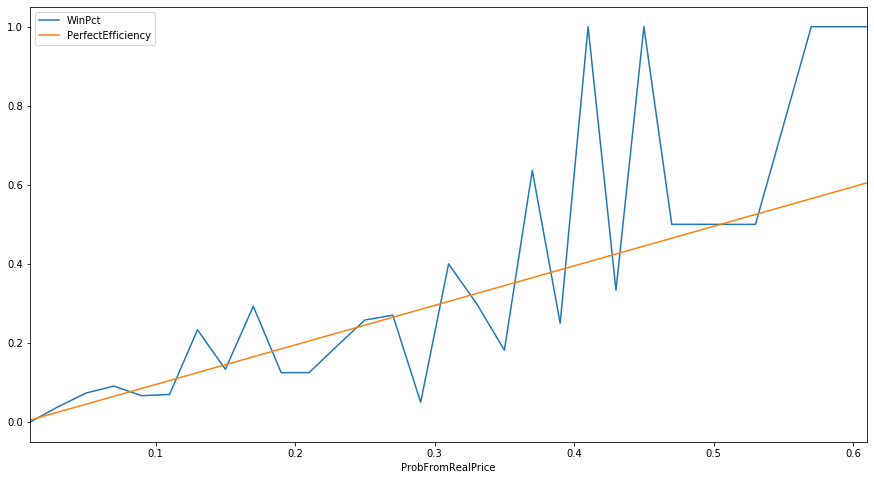

In [12]:
winPctByPrice = pd.DataFrame(columns=['ProbFromRealPrice', 'WinPct', 'PerfectEfficiency'])
ix = 0
cumAdvt = 0
for n in range(1,100, 2): #use step of 2 as data is a large sparcers
    prob_floor = (n-1) / 100
    prob_ceiling = n / 100
    winPct = drifters[(drifters.RealProd >= prob_floor) & (drifters.RealProd < prob_ceiling)].WIN.mean()
    perfectRangeAvg = (prob_floor + prob_ceiling)/2
    winPctByPrice.loc[ix] = [prob_ceiling, winPct, perfectRangeAvg]
    if np.isfinite(winPct):
        cumAdvt += (winPct - perfectRangeAvg)
    ix = ix + 1
        
print("Cumulative Advantage: {}".format(cumAdvt))
winPctByPrice.dropna(inplace=True)
winPctByPrice.plot(x='ProbFromRealPrice', y=['WinPct', 'PerfectEfficiency'], figsize=(15,8))

## Repeat for runners that have firmed 25% or more

In [13]:
firmers = raceStarters[(raceStarters.RawProb - raceStarters.RawProbOpenAdjusted) > 0.25]
firmers.head()

,RunnerName,RunnerNumber,FixedWinOpen,FixedWin,FixedPlace,BettingStatus,MeetingDate,MeetingName,RaceNumber,WinDeductionSum,FixedWinOpenAdjusted,RawProb,RawProbOpenAdjusted,MarketPct,RealProd,RealPrice,WIN
1477,START WONDERING,8,3.4,1.70,1.12,Loser,2016-01-02,ROSEHILL,8,3.0,3.328,0.588235,0.300481,1.183086,0.497204,2.011247,False
2192,MOOSEM,2,5.0,1.85,1.13,Placing,2016-01-03,NARACOORTE,1,27.0,3.920,0.540541,0.255102,1.172757,0.460914,2.169600,False
2712,INDELO,1,7.0,2.40,1.33,Loser,2016-01-04,WANGARATTA,8,5.0,6.700,0.416667,0.149254,1.274401,0.326951,3.058563,False
5160,LEAMI ASTRAY,4,2.5,1.24,1.04,Winner,2016-01-11,NOWRA,1,27.0,2.095,0.806452,0.477327,1.130821,0.713156,1.402218,True
9100,GUNDY MAGIC,2,8.0,1.80,1.22,Winner,2016-01-21,MACKAY,3,0.0,8.000,0.555556,0.125000,1.142107,0.486430,2.055793,True


Cumulative Advantage: 2.073368524300176


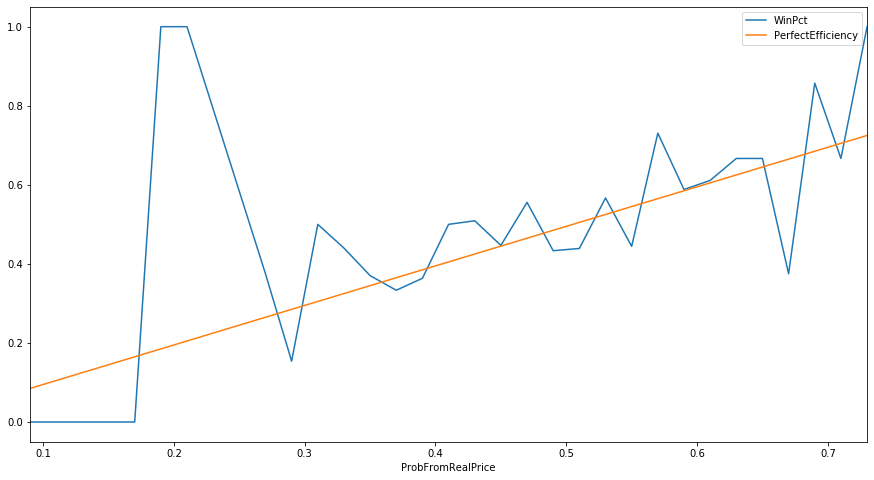

In [14]:
winPctByPrice = pd.DataFrame(columns=['ProbFromRealPrice', 'WinPct', 'PerfectEfficiency'])
ix = 0
cumAdvt = 0
for n in range(1,100, 2): #use step of 2 as data is a sparce
    prob_floor = (n-1) / 100
    prob_ceiling = n / 100
    winPct = firmers[(firmers.RealProd >= prob_floor) & (firmers.RealProd < prob_ceiling)].WIN.mean()
    perfectRangeAvg = (prob_floor + prob_ceiling)/2
    winPctByPrice.loc[ix] = [prob_ceiling, winPct, perfectRangeAvg]
    if np.isfinite(winPct):
        cumAdvt += (winPct - perfectRangeAvg)
    ix = ix + 1
        
print("Cumulative Advantage: {}".format(cumAdvt))
winPctByPrice.dropna(inplace=True)
winPctByPrice.plot(x='ProbFromRealPrice', y=['WinPct', 'PerfectEfficiency'], figsize=(15,8))